In [28]:
import pickle
import cvxpy as cp
import pandas as pd
import numpy as np
import math
import torch
import itertools
import networkx as nx

data = pd.read_excel(r'LODF\IEEE27.xlsx',sheet_name=None)
Sbase = data['par']['base'][0]
lcontingencies = range(len(data['line']))
Nloads = len(data['load'])
Ngens = len(data['gen'])
Nlines = len(data['line'])
Nbus = len(data['bus'])
l = len(data['line'])
print(data["line"]['max_f'][0]/Sbase)


case = 'N-3'
Nlines = l

if case == 'N-1':
    file_path = 'violation indices/violation_list_scopf_N1.pkl'
    Nk_contingencies = np.array(list(itertools.combinations(range(Nlines),1)))
    Ncontingencies = len(Nk_contingencies)
if case == 'N-2':
    file_path = 'violation indices/violation_list_scopf_N2.pkl'
    Nk_contingencies = np.array(list(itertools.combinations(range(Nlines),2)))
    Ncontingencies = len(Nk_contingencies)
if case == 'N-3':
    file_path = 'violation indices/violation_list_scopf_N3.pkl'
    Nk_contingencies = np.array(list(itertools.combinations(range(Nlines),3)))
    Ncontingencies = len(Nk_contingencies)


with open(file_path, 'rb') as f:
    violation_indices_scopf = pickle.load(f)
    
if case == 'N-1':
    file_path = 'violation indices/violation_list_nn_N1.pkl'
if case == 'N-2':
    file_path = 'violation indices/violation_list_nn_N2.pkl'
if case == 'N-3':
    file_path = 'violation indices/violation_list_nn_N3.pkl'


with open(file_path, 'rb') as f:
    violation_indices_nn = pickle.load(f)



10.0


In [29]:
def calculate_indices_metrics(scopf_tensor, nn_tensor):
    # Convert tensors to sets of tuples for efficient membership testing
    scopf_set = set(tuple(pair) for pair in scopf_tensor.view(-1, 2).tolist())
    nn_set = set(tuple(pair) for pair in nn_tensor.view(-1, 2).tolist())

    # Calculate the total number of pairs in each tensor
    total_pairs_scopf = len(scopf_set)
    total_pairs_nn = len(nn_set)

    # Calculate the intersection of pairs (common pairs)
    common_pairs = scopf_set.intersection(nn_set)

    # Calculate the number of pairs unique to each tensor
    unique_pairs_scopf = total_pairs_scopf - len(common_pairs)
    unique_pairs_nn = total_pairs_nn - len(common_pairs)

    # Calculate the overlap (common pairs)
    overlap = len(common_pairs)

    # Calculate the percentages
    percentage_unique_scopf = (unique_pairs_scopf / total_pairs_scopf) * 100
    percentage_unique_nn = (unique_pairs_nn / total_pairs_nn) * 100

    return total_pairs_scopf, total_pairs_nn, unique_pairs_scopf, unique_pairs_nn, overlap, percentage_unique_scopf, percentage_unique_nn


total_pairs_scopf, total_pairs_nn, unique_pairs_scopf, unique_pairs_nn, overlap, percentage_unique_scopf, \
percentage_unique_nn = calculate_indices_metrics(violation_indices_scopf, violation_indices_nn)

print("Total Pairs in 'scopf':", total_pairs_scopf)
print("Total Pairs in 'nn':", total_pairs_nn)
print("Unique Pairs in 'scopf':", unique_pairs_scopf)
print("Unique Pairs in 'nn':", unique_pairs_nn)
print("Overlap between 'scopf' and 'nn':", overlap)
print("Percentage Unique in 'scopf':", percentage_unique_scopf)
print("Percentage Unique in 'nn':", percentage_unique_nn)

violation_list_scopf = torch.zeros((Ncontingencies,1))
for i in range(len(violation_indices_scopf)):
    contingency = violation_indices_scopf[i,0] 
    violation_list_scopf[contingency,0] += 1
    
violation_list_nn = torch.zeros((Ncontingencies,1))
for i in range(len(violation_indices_nn)):
    contingency = violation_indices_nn[i,0] 
    violation_list_nn[contingency,0] += 1
    
print(violation_list_scopf.T)
print(violation_list_nn[0,-100:].T)

Total Pairs in 'scopf': 179971
Total Pairs in 'nn': 117624
Unique Pairs in 'scopf': 110058
Unique Pairs in 'nn': 47711
Overlap between 'scopf' and 'nn': 69913
Percentage Unique in 'scopf': 61.153185791044116
Percentage Unique in 'nn': 40.56230021084132
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0.])


In [30]:
line_dict = {}
line_violation_dict = {}

for i in range(Nlines):
    line_dict[i] = [data['line']['from_bus'][i], data['line']['to_bus'][i]]

line_violation_list_scopf = torch.zeros((Nlines,1))
for i in range(len(violation_list_scopf)):
    line_indices = Nk_contingencies[i,:]
    amount = violation_list_scopf[i,0] 
    line_violation_list_scopf[line_indices,0] += amount
    
line_violation_list_nn = torch.zeros((Nlines,1))
for i in range(len(violation_list_nn)):
    line_indices = Nk_contingencies[i,:]
    amount = violation_list_nn[i,0] 
    line_violation_list_nn[line_indices,0] += amount
    
for i in range(Nlines):
    line_dict[i] = [data['line']['from_bus'][i], data['line']['to_bus'][i]]
    line_violation_dict[i] = [data['line']['from_bus'][i], data['line']['to_bus'][i], line_violation_list_nn[i]]

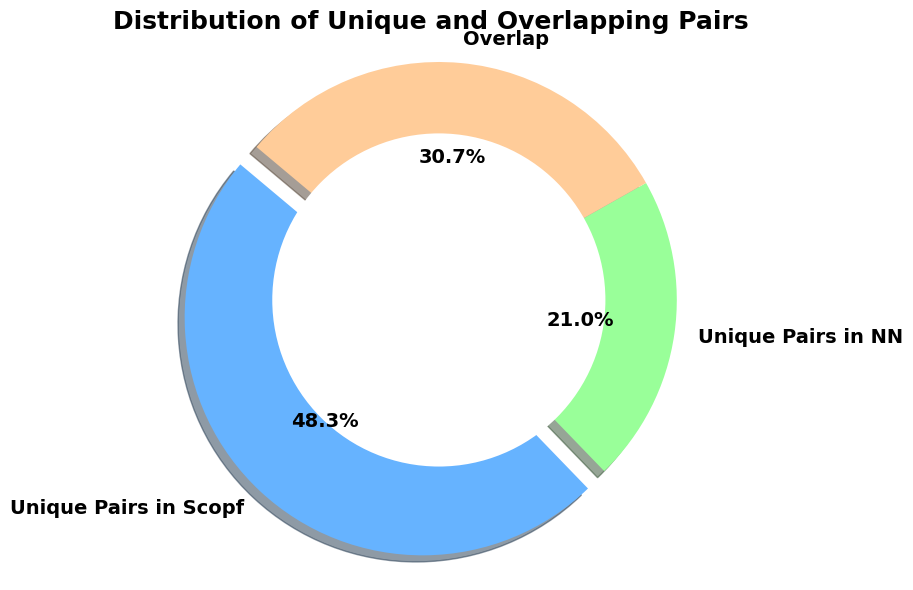

In [31]:
import matplotlib.pyplot as plt

# Calculate the total number of unique pairs in 'scopf', 'nn', and the overlapping pairs
total_unique_pairs_scopf = unique_pairs_scopf
total_unique_pairs_nn = unique_pairs_nn
total_overlap_pairs = overlap

# Create data for the pie chart
labels = ['Unique Pairs in Scopf', 'Unique Pairs in NN', 'Overlap']
sizes = [total_unique_pairs_scopf, total_unique_pairs_nn, total_overlap_pairs]
colors = ['#66b3ff', '#99ff99', '#ffcc99']  # Soft pastel colors
explode = (0.1, 0, 0)  # Explode the 1st slice (Unique Pairs in Scopf)

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=140, textprops={'fontsize': 14, 'fontweight': 'bold'})

# Draw a white circle in the center for a donut chart effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Distribution of Unique and Overlapping Pairs', fontsize=18, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the pie chart
plt.tight_layout()
plt.show()


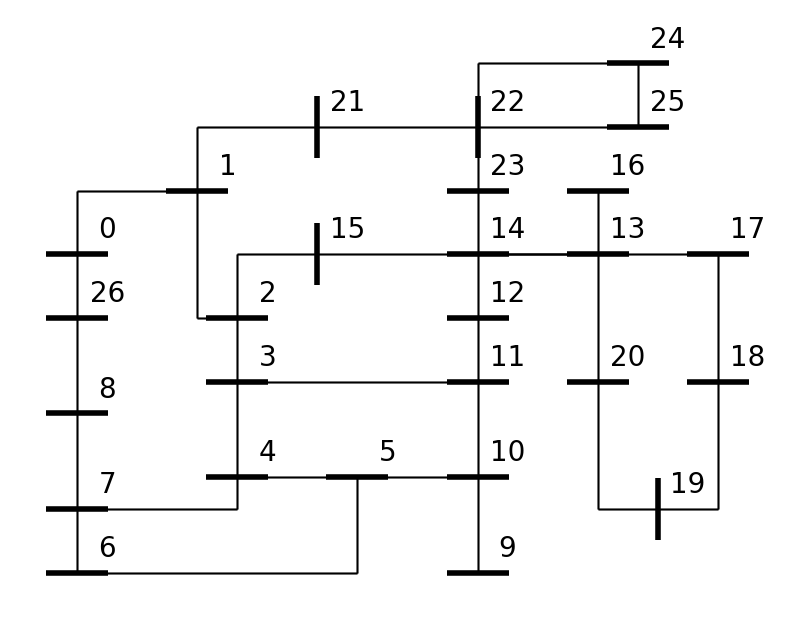

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# x_coordinates and y_coordinates contain the coordinates for each node
x_coordinates = data['bus']['x']
y_coordinates = data['bus']['y']

# Create a graph from the dataset
G = nx.Graph()
G.add_edges_from(zip(data["line"]["from_bus"], data["line"]["to_bus"]))

# Create a dictionary of node positions using x and y coordinates
node_positions = {node: (x_coordinates[node], y_coordinates[node]) for node in G.nodes()}
node_shapes = ['_','_','_','_','|','_','|','_','_','_','_','_','_','_','_','_','_','_','_','_','_','_','_','|','|','_','_']


def add_horizontal_vertical_edges(G, u, v, pos, distance_factor=1):
    # If the nodes have the same x-coordinate
    if pos[u][0] == pos[v][0]:
        # They're already vertically aligned, so just add the edge and return
        G.add_edge(u, v)
        return

    # If the nodes have the same y-coordinate
    if pos[u][1] == pos[v][1]:
        # They're already horizontally aligned, so just add the edge and return
        G.add_edge(u, v)
        return

    # Add two intermediate nodes
    intermediate_node_1 = f"{u}_{v}_int1"
    intermediate_node_2 = f"{u}_{v}_int2"

    # First intermediate node: horizontally aligned with source node (u) and vertically aligned with target node (v)
    pos[intermediate_node_1] = (pos[u][0], pos[u][1] + distance_factor * (pos[v][1] - pos[u][1]))

    # Second intermediate node: horizontally aligned with target node (v) and vertically aligned with the first intermediate node
    pos[intermediate_node_2] = (pos[u][0] + distance_factor * (pos[v][0] - pos[u][0]), pos[intermediate_node_1][1])

    # Add the intermediate nodes to the graph
    G.add_node(intermediate_node_1)
    G.add_node(intermediate_node_2)

    # Add edges
    G.add_edge(u, intermediate_node_1)
    G.add_edge(intermediate_node_1, intermediate_node_2)
    G.add_edge(intermediate_node_2, v)


edge_mapping = {}

# Recreate the graph from the dataset
G = nx.Graph()
G.add_edges_from(zip(data["line"]["from_bus"], data["line"]["to_bus"]))

# Create a copy of the edges since we'll modify the original graph
edges = list(G.edges())
for index, edge in enumerate(edges):
    u, v = edge
    G.remove_edge(u, v)  # Remove the original edge
    add_horizontal_vertical_edges(G, u, v, node_positions)  # Add the modified edges
    
    # Get the newly added edges
    new_edges = [(u, f"{u}_{v}_int1"), (f"{u}_{v}_int1", f"{u}_{v}_int2"), (f"{u}_{v}_int2", v)]
    
    # Filter the new_edges to include only those that are in G.edges
    new_edges = [new_edge for new_edge in new_edges if new_edge in G.edges()]
    
    # Map the original edge to the filtered newly added edges
    edge_mapping[edge] = new_edges
    
    
# Draw the modified graph
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(G, node_positions, with_labels=False, node_color='black', node_size=0, node_shape='_', font_size=8, ax=ax)
nx.draw_networkx_edges(G, node_positions, width=2.0, alpha=0.5, ax=ax)

for node, marker in zip(G.nodes(), node_shapes):
    x, y = node_positions[node]
    nx.draw_networkx_nodes(G, node_positions, nodelist=[node],node_color='black', linewidths = 4, node_size=2000, node_shape=marker, ax=ax)


# Draw node labels
label_positions = {node: (x+0.75, y + 0.75) for node, (x, y) in node_positions.items() if "int" not in str(node)}
nx.draw_networkx_labels(G, pos=label_positions, font_size=20, font_color='black', labels={i: f'{i}' for i in G.nodes() if "int" not in str(i)})

plt.savefig("39bus_single_line.pdf", format="pdf")

plt.show()

counts = []

# Iterate through the 'edge_mapping' dictionary and count the entries in each key's value list
for key, value in edge_mapping.items():
    count = len(value)

    # Add 1 if the key has no entries (empty list)
    if not value:
        count += 1
    
    counts.append(count)

In [33]:
original_list = G.edges
new_list = []


for edge in original_list:
    u, v = edge
    if isinstance(v, int):
        new_entry = (u, v)
    else:
        a, b, c = v.split('_')
        if a != str(u):
            new_entry = (u, int(a))
        else:
            new_entry = (u, int(b))
    new_list.append(new_entry)
    
second_list = []

for edge in new_list:
    u, v = edge
    if isinstance(u, int):
        new_entry = (u, v)
    else:
        a, b, c = u.split('_')
        if a != str(v):
            new_entry = (int(a),v)
        else:
            new_entry = (int(b),v)
    second_list.append(new_entry)

entry_list = second_list
key_dict = line_dict  
    
# Initialize an empty list to store the indices of matching keys
matching_keys = []

# Iterate through the entries in entry_list
for entry in entry_list:
    # Sort the entry to ensure order doesn't matter
    sorted_entry = tuple(sorted(entry))
    
    # Iterate through the dictionary items
    for key, indices in key_dict.items():
        key_entry = tuple(sorted(indices))
        if sorted_entry == key_entry:
            matching_keys.append(key)

    

In [34]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

C:\Users\basti\AppData\Local\Temp\ipykernel_15632\1398986246.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Use viridis colormap for clear colors


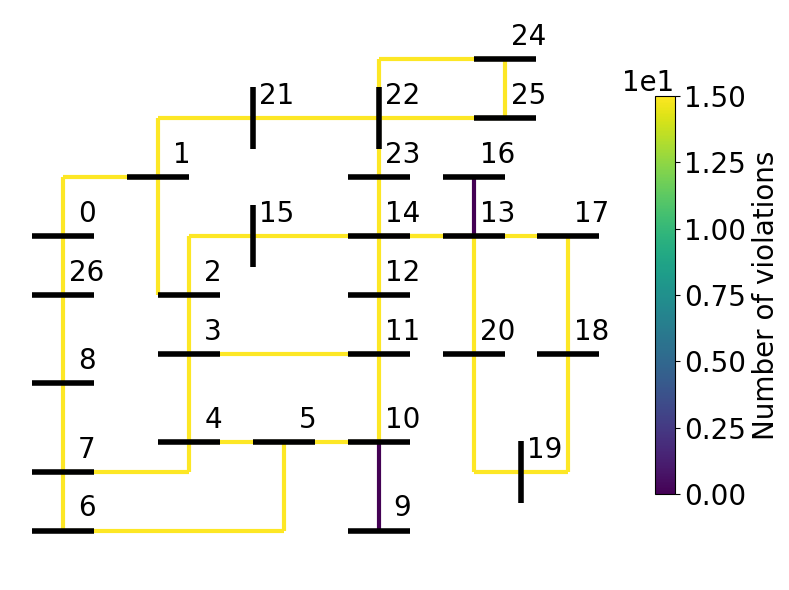

{0: [0, 1, tensor([18051.])], 1: [0, 26, tensor([8319.])], 2: [1, 2, tensor([21456.])], 3: [1, 21, tensor([6424.])], 4: [2, 3, tensor([7048.])], 5: [2, 15, tensor([5493.])], 6: [3, 4, tensor([11804.])], 7: [3, 11, tensor([19218.])], 8: [4, 5, tensor([31646.])], 9: [4, 7, tensor([10746.])], 10: [5, 6, tensor([47833.])], 11: [5, 10, tensor([3553.])], 12: [6, 7, tensor([11090.])], 13: [7, 8, tensor([5234.])], 14: [8, 26, tensor([5529.])], 15: [9, 10, tensor([0.])], 16: [10, 11, tensor([34108.])], 17: [11, 12, tensor([6480.])], 18: [12, 13, tensor([7433.])], 19: [13, 14, tensor([7639.])], 20: [13, 16, tensor([0.])], 21: [13, 17, tensor([4287.])], 22: [13, 20, tensor([4287.])], 23: [14, 15, tensor([10685.])], 24: [14, 23, tensor([4923.])], 25: [17, 18, tensor([9081.])], 26: [18, 19, tensor([4287.])], 27: [19, 20, tensor([9081.])], 28: [21, 22, tensor([9712.])], 29: [22, 23, tensor([11870.])], 30: [22, 24, tensor([5185.])], 31: [22, 25, tensor([5185.])], 32: [24, 25, tensor([5185.])]}


In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tikzplotlib
from matplotlib.ticker import ScalarFormatter

values = line_violation_list_nn
result = torch.ones(len(matching_keys))

for i in range(len(result)):
    result[i] = values[matching_keys[i],:]


def plot_graph_with_colorbar(graph, edge_intensities):
    # Extract node coordinates
    pos = node_positions #nx.get_node_attributes(graph, 'coordinates')
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define the colormap
    cmap = cm.get_cmap('viridis')  # Use viridis colormap for clear colors
    
    # Normalize the edge intensities to the range [0, 1]
    #norm = plt.Normalize(vmin=min(edge_intensities), vmax=max(edge_intensities))
    norm = plt.Normalize(vmin=min(edge_intensities), vmax=15)
    
    # Create a ScalarMappable to map normalized values to colors
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Plot edges with colors based on edge intensities
    edge_colors = cmap(norm(edge_intensities))
    nx.draw(graph, pos, node_color='black', node_size=0, width=3.0, edge_color=edge_colors, ax=ax)
    
    for node, marker in zip(G.nodes(), node_shapes):
        x, y = node_positions[node]
        nx.draw_networkx_nodes(G, node_positions, nodelist=[node],node_color='black', linewidths = 4, node_size=2000, node_shape=marker, ax=ax)

    label_positions = {node: (x+0.75, y+0.75) for node, (x, y) in node_positions.items() if "int" not in str(node)}
    nx.draw_networkx_labels(G, pos=label_positions, font_size=20, font_color='black', labels={i: f'{i}' for i in G.nodes() if "int" not in str(i)})


    # Add a colorbar to show edge intensities
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)
    cbar.set_label('Number of violations', fontsize=20)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    #cbar.formatter.set_useMathText(True)
    cbar.ax.tick_params(labelsize=20)
    for t in cbar.ax.yaxis.get_offset_text(), cbar.ax.yaxis.get_offset_text():
        t.set(size=20) 

    # Customize plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_tick_params(size=5)
    ax.yaxis.set_tick_params(size=5)
    ax.xaxis.set_tick_params(width=1, color='black')
    ax.yaxis.set_tick_params(width=1, color='black')
    
    plt.xlabel('X', color='black', labelpad=12)
    plt.ylabel('Y', color='black', labelpad=12)
    
    plt.tight_layout()
#     plt.savefig("39bus_violations_NN_N1.pdf", format="pdf")
#     tikzplotlib_fix_ncols(plt.gcf())
#     tikzplotlib.save('39bus_violations_NN_N3.tex')
    plt.show()


plot_graph_with_colorbar(G, result)
print(line_violation_dict)

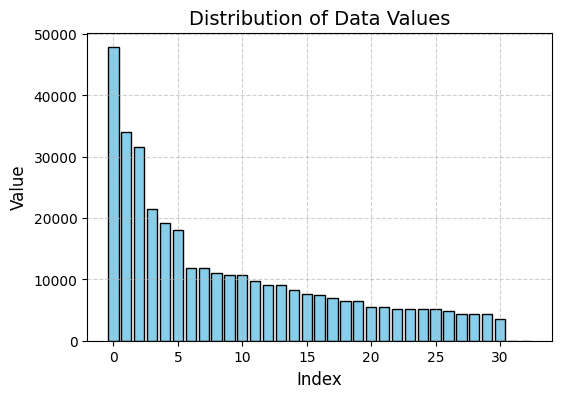

In [37]:
violations = line_violation_list_nn.squeeze(1)

sorted_data = np.sort(violations)[::-1]

# Create a figure and adjust the figure size for a paper
plt.figure(figsize=(6, 4))

# Create the bar plot with specified colors and edgecolor
plt.bar(range(len(sorted_data)), sorted_data, color='skyblue', edgecolor='black')

# Add title and labels with LaTeX-style formatting
plt.title(r'Distribution of Data Values', fontsize=14)
plt.xlabel(r'Index', fontsize=12)
plt.ylabel(r'Value', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Customize tick labels, if necessary
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot as a high-quality PDF for inclusion in the paper
tikzplotlib_fix_ncols(plt.gcf())
tikzplotlib.save('39bus_violations_NN_N3.tex')

# Display the plot (optional)
# plt.show()



C:\Users\basti\AppData\Local\Temp\ipykernel_14748\2322295176.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds', 256)


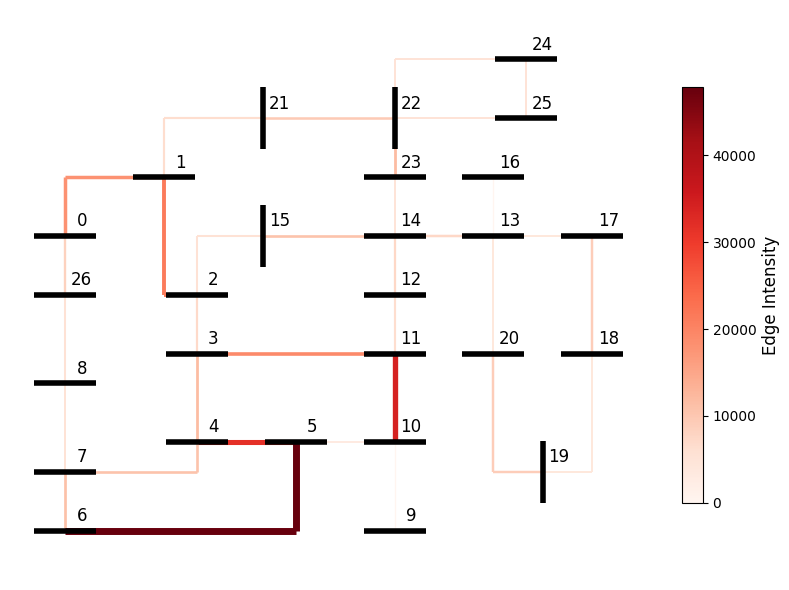

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_graph_with_colorbar(graph, edge_intensities):
    # Extract node coordinates
    pos = node_positions #nx.get_node_attributes(graph, 'coordinates')

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define a colormap with distinct colors
    cmap = cm.get_cmap('Reds', 256)

    # Normalize the edge intensities to the range [0, 1]
    norm = plt.Normalize(vmin=min(edge_intensities), vmax=max(edge_intensities))

    # Create a ScalarMappable to map normalized values to colors
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Plot edges with colors based on edge intensities
    edge_colors = cmap(norm(edge_intensities))
    linewidths = 1 + 4 * (edge_intensities - min(edge_intensities)) / (max(edge_intensities) - min(edge_intensities))
    nx.draw(graph, pos, node_color='black', node_size=0, width=linewidths, edge_color=edge_colors, ax=ax)
    
    for node, marker in zip(G.nodes(), node_shapes):
        x, y = node_positions[node]
        nx.draw_networkx_nodes(G, node_positions, nodelist=[node],node_color='black', linewidths = 4, node_size=2000, node_shape=marker, ax=ax)

    label_positions = {node: (x+0.5, y + 0.5) for node, (x, y) in node_positions.items() if "int" not in str(node)}
    nx.draw_networkx_labels(G, pos=label_positions, font_size=12, font_color='black', labels={i: f'{i}' for i in G.nodes() if "int" not in str(i)})


    # Add a colorbar to show edge intensities
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)
    cbar.set_label('Edge Intensity', fontsize=12)

    # Customize plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_tick_params(size=1)
    ax.yaxis.set_tick_params(size=1)
    ax.xaxis.set_tick_params(width=1, color='black')
    ax.yaxis.set_tick_params(width=1, color='black')

    plt.xlabel('X', color='black', labelpad=12)
    plt.ylabel('Y', color='black', labelpad=12)

    plt.tight_layout()
    plt.show()

plot_graph_with_colorbar(G, result)


In [ ]:
def scale_coordinates(coordinates, xmin, xmax, ymin, ymax):
    min_x = min(coordinates, key=lambda c: c[0])[0]
    max_x = max(coordinates, key=lambda c: c[0])[0]
    min_y = min(coordinates, key=lambda c: c[1])[1]
    max_y = max(coordinates, key=lambda c: c[1])[1]

    scaled_coordinates = []
    for x, y in coordinates:
        scaled_x = ((x - min_x) / (max_x - min_x)) * (xmax - xmin) + xmin
        scaled_y = ((y - min_y) / (max_y - min_y)) * (ymax - ymin) + ymin
        scaled_coordinates.append((scaled_x, scaled_y))

    return scaled_coordinates

# Create a graph from the dataset
G = nx.Graph()
G.add_edges_from(zip(data["line"]["from_bus"], data["line"]["to_bus"]))

# Randomly assign coordinates using the spring layout algorithm
pos = nx.spring_layout(G, seed=56)

# Scale the coordinates to fit within the desired range
scaled_coordinates = scale_coordinates(pos.values(), 0, 200, 0, 200)

# Update the node coordinates in the graph
for node, coordinates in zip(G.nodes(), scaled_coordinates):
    G.nodes[node]["coordinates"] = coordinates

# Compute edge lengths based on the scaled node coordinates
for u, v in G.edges():
    coordinates_u = G.nodes[u]["coordinates"]
    coordinates_v = G.nodes[v]["coordinates"]
    length = math.dist(coordinates_u, coordinates_v)
    G.edges[u, v]["length"] = length

# Print the lengths of each edge
for u, v in G.edges():
    length = G.edges[u, v]["length"]
    #print(f"Edge ({u}, {v}): Length = {length}")

# Draw the graph with node coordinates
fig, ax = plt.subplots()
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, ax=ax)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)

plt.show()